<a href="https://colab.research.google.com/github/Ola2808-Boro/ECG-signal-denoising/blob/main/Projekt_OPSI_Borowska_Lewko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising ECG

1.   EMD
2.   Autoregressive Model
3.   Wavelet Transform

In [ ]:
!pip install wfdb
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#contect with dataset which is located on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import wfdb
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pywt
import sys
import statistics
from math import log10
from scipy.signal import find_peaks
from scipy.signal import resample
import math
from scipy.fftpack import fft
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats.stats import pearsonr   
from sklearn.metrics import mean_squared_error,mean_absolute_error

<ipython-input-118-b838c4a88de8>:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
# Read signals from dataset
# 48 signals
def readSignals(records):
    data = []
    samples_rate=[]
    for rec in records:
        path = rec[:-4]
        x, y = wfdb.rdsamp(path, channels=[0,1])
        data.append((x[:,0]))
        samples_rate.append(y['fs'])
    return data,samples_rate

path='/content/drive/MyDrive/ColabNotebooks/mit-bih-arrhythmia-database-1.0.0/'
records=glob.glob(path+"*.atr")
data,samples_rate=readSignals(records[:]) 
nsignals = len(data)

Drawing ECG Signal functions

In [ ]:
def draw_all_ecg_signal(data_ecg_signals):
  fig = plt.figure(figsize=(20, 50))
  for i in range(0, 48):
    ax = fig.add_subplot(24,2,i+1)
    ax.plot(data_ecg_signals[i][:1200])
    ax.set_title('Signal {}'.format(i+1))
    ax.set_xlabel("Samples")
    ax.set_ylabel('Amplitude [mV]')

  fig.tight_layout(pad=0.7)
  plt.show()

In [ ]:
def draw_ecg_signal(data):
  plt.figure(figsize=(18,6))
  plt.plot(data[:1200])
  plt.title("Example of ECG signal")
  plt.xlabel("Samples")
  plt.ylabel("Amplitude [mV]")
  plt.show()



In [ ]:
def draw_noised_original_ecg_signal(noise_signal,original_signal):
  plt.suptitle('Noise and original ECG signal')
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(1,1,1)
  ax.plot(noise_signal[:1200],'r',label='Noisy Signal')
  ax.plot(original_signal[:1200],'b',label='Orginal Signal')
  ax.legend()
  plt.show()

In [ ]:
def draw_noised_original_denoised_ecg_signal(noise_signal,original_signal,denoised_data):
  plt.suptitle('Noise and original ECG signal')
  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(1,1,1)
  ax.plot(noise_signal[:1200],'r',label='Noisy Signal')
  ax.plot(original_signal[:1200],'b',label='Orginal Signal')
  ax.plot(denoised_data[:1200],'g',label='Denoised Signal')
  ax.legend()
  plt.show()

In [ ]:
def draw_differential_signal(signal_1,signal_2):
  differential=signal_1-signal_2
  plt.figure(figsize=(18,6))
  plt.plot(differential[:1200])
  plt.title("Differential signal")
  plt.xlabel("Samples")
  plt.ylabel("Amplitude [mV]")
  plt.show()

In [ ]:
def plot_spectrum(signal):
  plt.figure(figsize=(18,6))
  plt.plot(np.abs(signal))
  plt.title('Signal in frequency domain')
  plt.xlabel('Frequency [Hz]')
  plt.show()

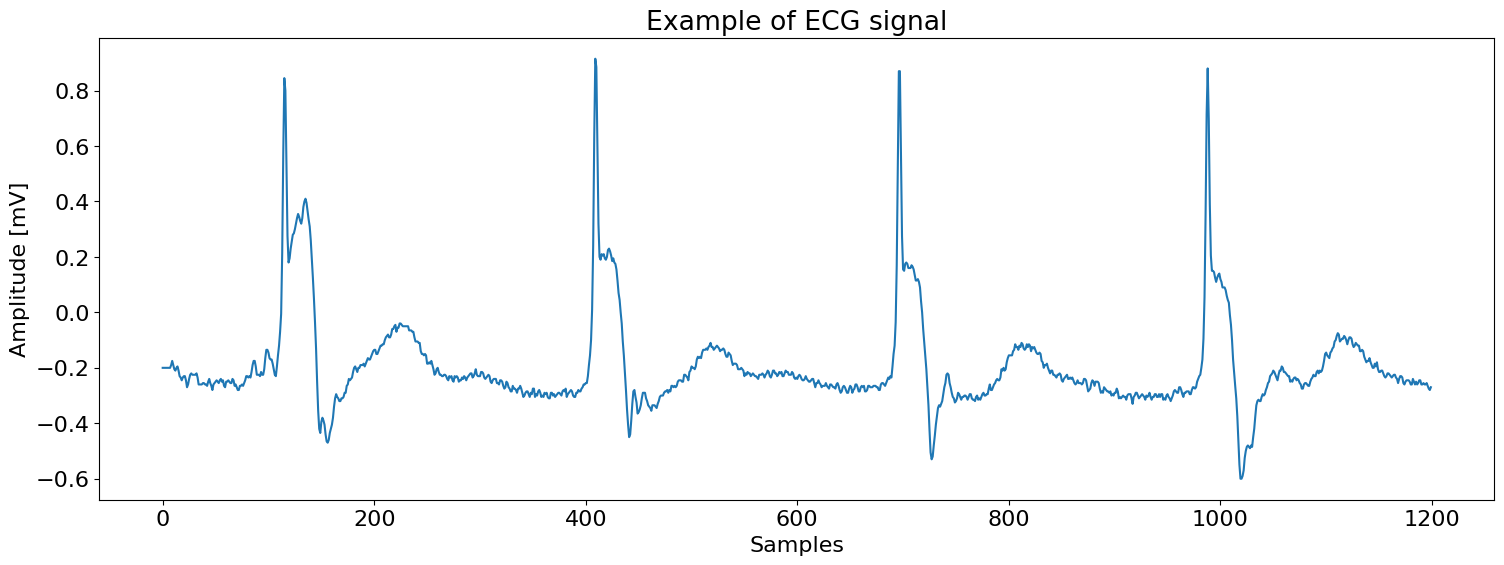

In [ ]:
draw_ecg_signal(data[4])


Signal noise

In [ ]:
def noise_normal_data(data, mean, std, amplitude=1,seed=None):
  noist_data=[]
  for j in range(nsignals):
      ndarray=data[j]
      output = np.zeros((1, len(ndarray)))
      if seed is not None:
        np.random.seed(seed)
      noise = np.random.normal(mean, std, len(ndarray))
      output= ndarray + noise
      noist_data.append(amplitude*output)
  return noist_data


In [ ]:
#Noise parameters
#Noise with normal distribution
sig_mean = 0
sig_std = 0.05
sig_ampl = 1

noisy_data = noise_normal_data(data,mean=sig_mean, std=sig_std, amplitude=sig_ampl, seed=100)

Denoising ECG

Algorithm 1 - Empirical Mode Decomposition

In [ ]:
def calculate_fourier(signal):
  return np.abs(fft(signal))

In [ ]:
def emd_calculate_parameters(sampling_rate):
  sampling_rate=360
  fs=1/sampling_rate
  tAxis=np.linspace(0,len(data[5]),len(data[5]*fs))
  return tAxis

In [ ]:
def local_extrema(signal, end_plot):

  upper_peaks, _ = find_peaks(signal)
  lower_peaks, _ = find_peaks(-signal)
  
  plt.rcParams.update({'font.size' : 16})
  plt.figure(figsize = (18,8))
  plt.plot(signal[:end_plot])
  plt.plot(upper_peaks[:end_plot],signal[upper_peaks[:end_plot]],'o',label = 'Upper peaks')
  plt.plot(lower_peaks[:end_plot],signal[lower_peaks[:end_plot]],'o',label = 'Lower peaks')
  plt.xlabel('Time [s]')
  plt.legend(loc = 'upper left')
  return upper_peaks,lower_peaks

In [ ]:
def interpolate_cubic_fun(upper_peaks,lower_peaks,signal,tAxis,end_plot):
  f1 = interp1d(upper_peaks,signal[upper_peaks], kind = 'cubic', fill_value = 'extrapolate')
  f2 = interp1d(lower_peaks,signal[lower_peaks], kind = 'cubic', fill_value = 'extrapolate')

  y1 = f1(tAxis)
  y2 = f2(tAxis)


  y1[0:5] = 0
  y1[-5:] = 0
  y2[0:5] = 0
  y2[-5:] = 0
  avg_envelope = (y1 + y2) / 2


  plt.figure(figsize = (18,8))
  plt.plot(tAxis[:end_plot],signal[:end_plot], label = 'signal')
  plt.plot(tAxis[:end_plot],y1[:end_plot], label = 'upper envelope')
  plt.plot(tAxis[:end_plot],y2[:end_plot], label = 'lower envelope')
  plt.plot(tAxis[:end_plot],avg_envelope[:end_plot], label = 'average envelope')
  plt.title('Visualizing envelopes')
  plt.xlim(0,360)
  plt.xlabel('Time [s]')
  plt.legend(loc = 'lower right')

  return avg_envelope

In [ ]:
def calculate_res(avg_envelope,tAxis,xfft,signal,end_plot,iternation):
  res = avg_envelope
  imf1 = signal[:end_plot] - avg_envelope[:end_plot]
  # Calculate Fast Fourier Transform
  xfft = np.abs(fft(res,1024))
  
  plt.figure(figsize = (20,8))
  plt.subplot(1,2,1)
  plt.plot(tAxis[:end_plot],res[:end_plot])
  plt.xlabel('Time [s]')
  plt.title('Signal residual in the {} iteration'.format(iternation))
  plt.subplot(1,2,2)
  plt.plot(xfft[:end_plot])
  plt.xlabel('Frequency [Hz]')
  plt.title('Signal residual spectrum in the {} iteration'.format(iternation))

  return res

In [ ]:
def emd_res(signal,end_plot,iteration):
  samples_rate=360
  tAxis=emd_calculate_parameters(samples_rate)
  upper_peaks,lower_peaks=local_extrema(signal,end_plot)
  avg_envelope=interpolate_cubic_fun(upper_peaks,lower_peaks,signal,tAxis,end_plot)
  residue=calculate_res(avg_envelope,tAxis,calculate_fourier(signal),signal,end_plot,iteration)
  return residue


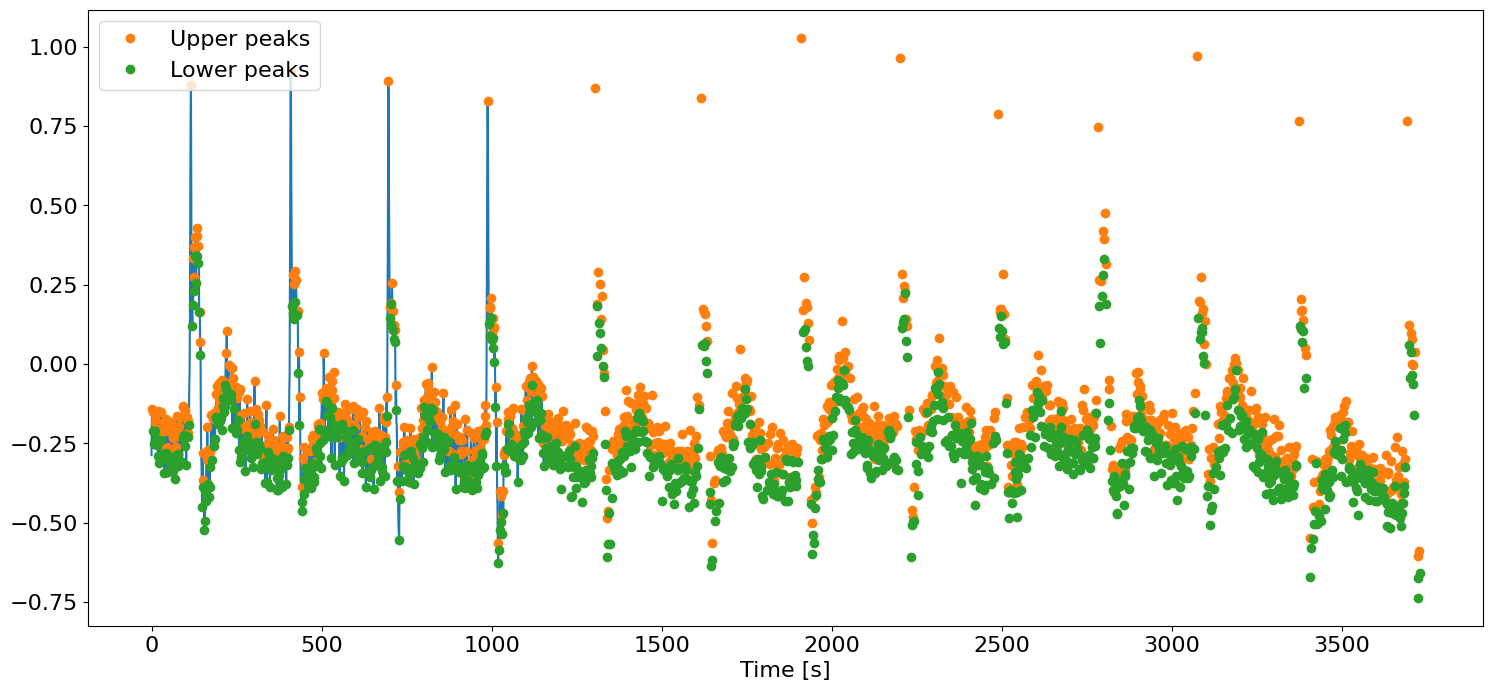

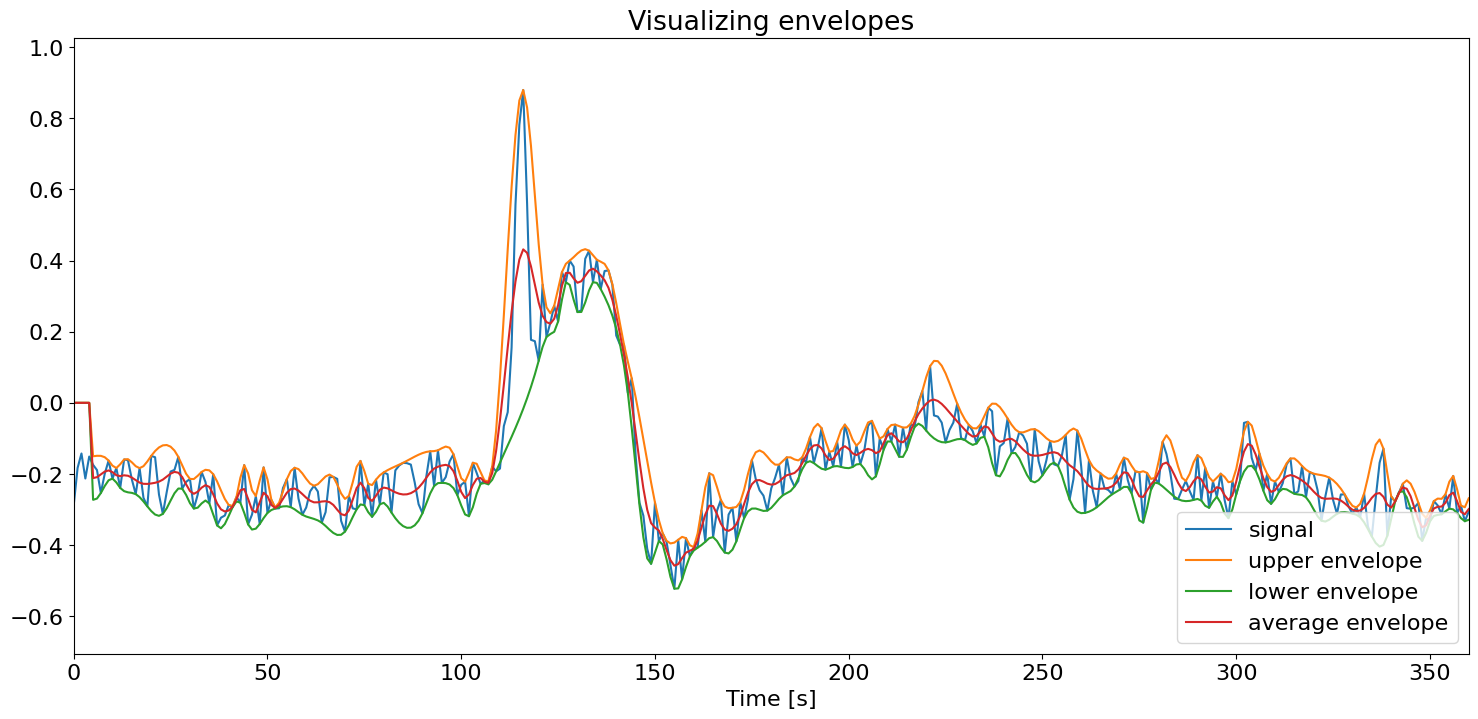

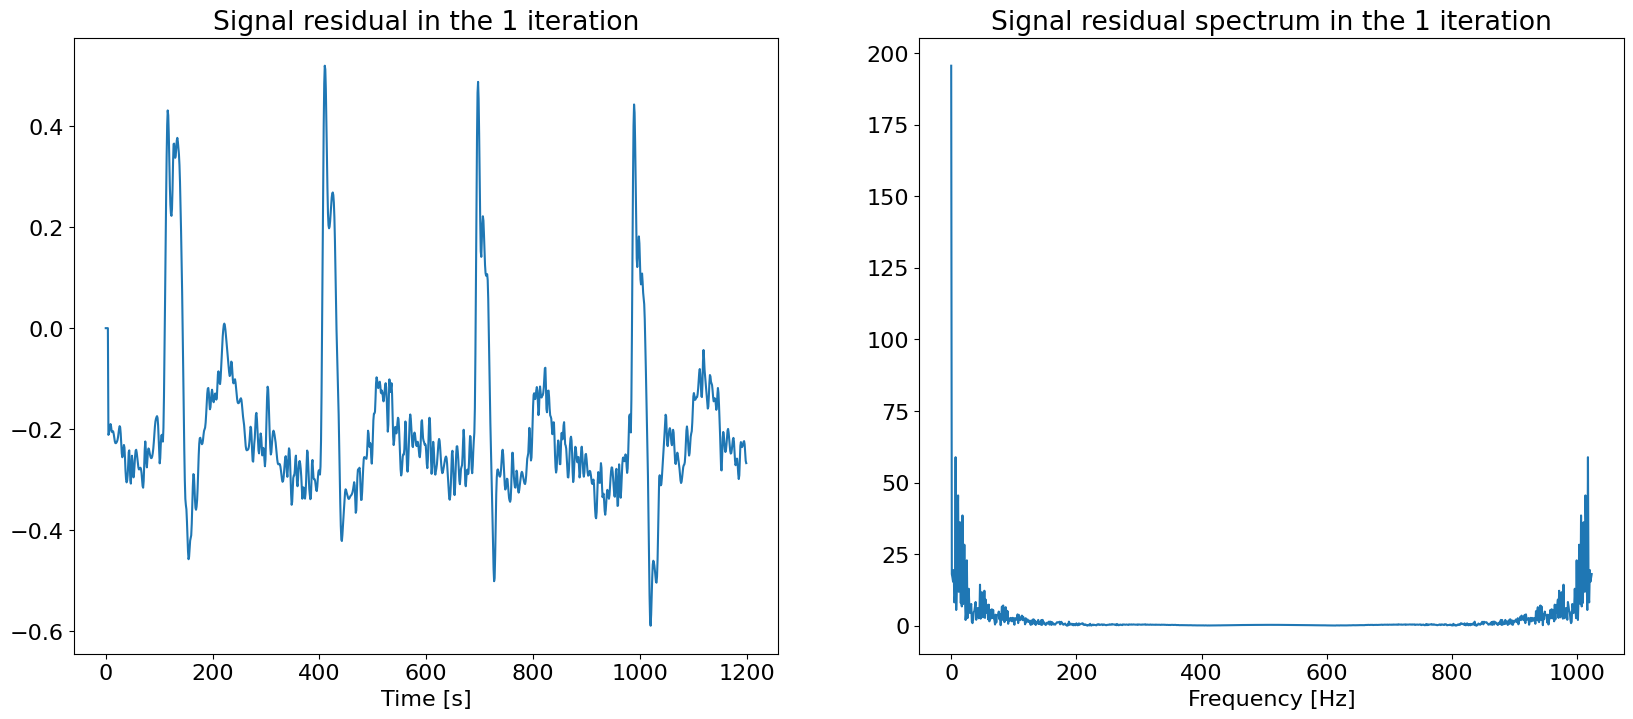

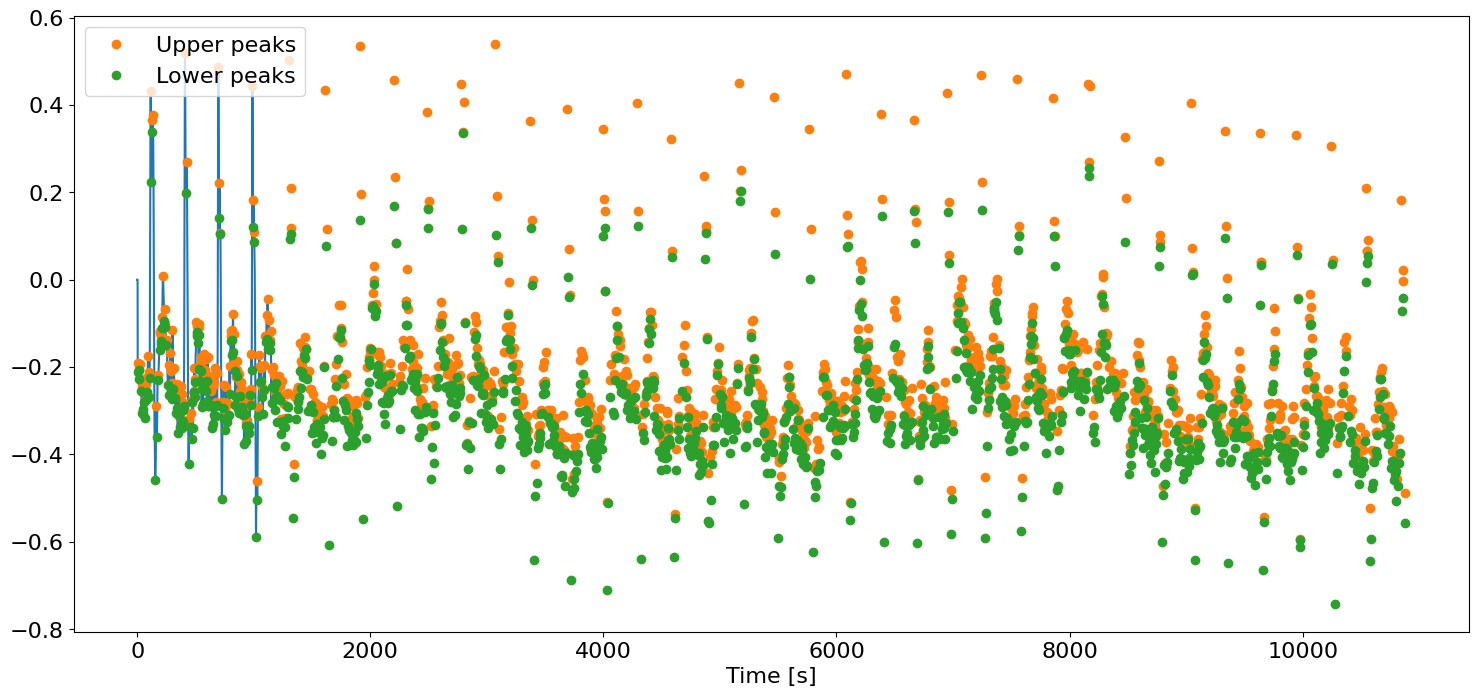

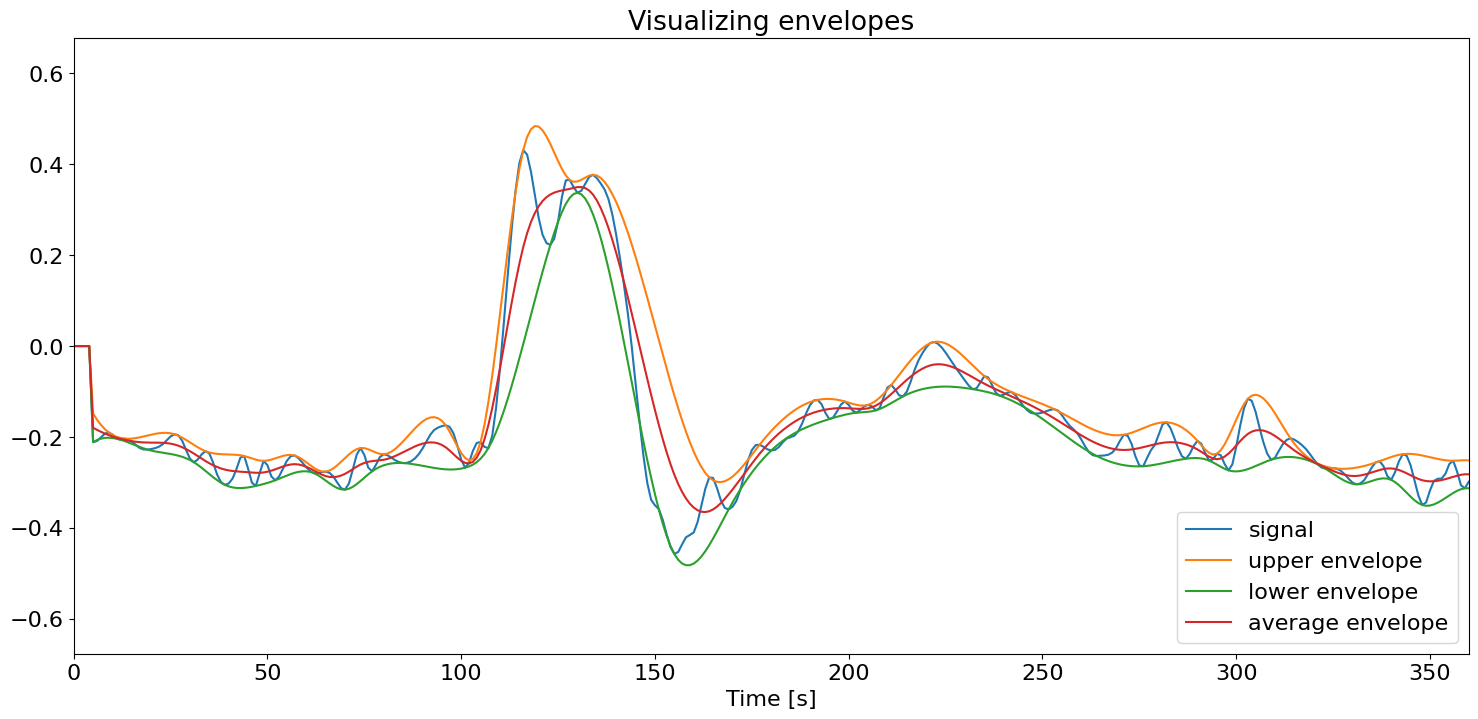

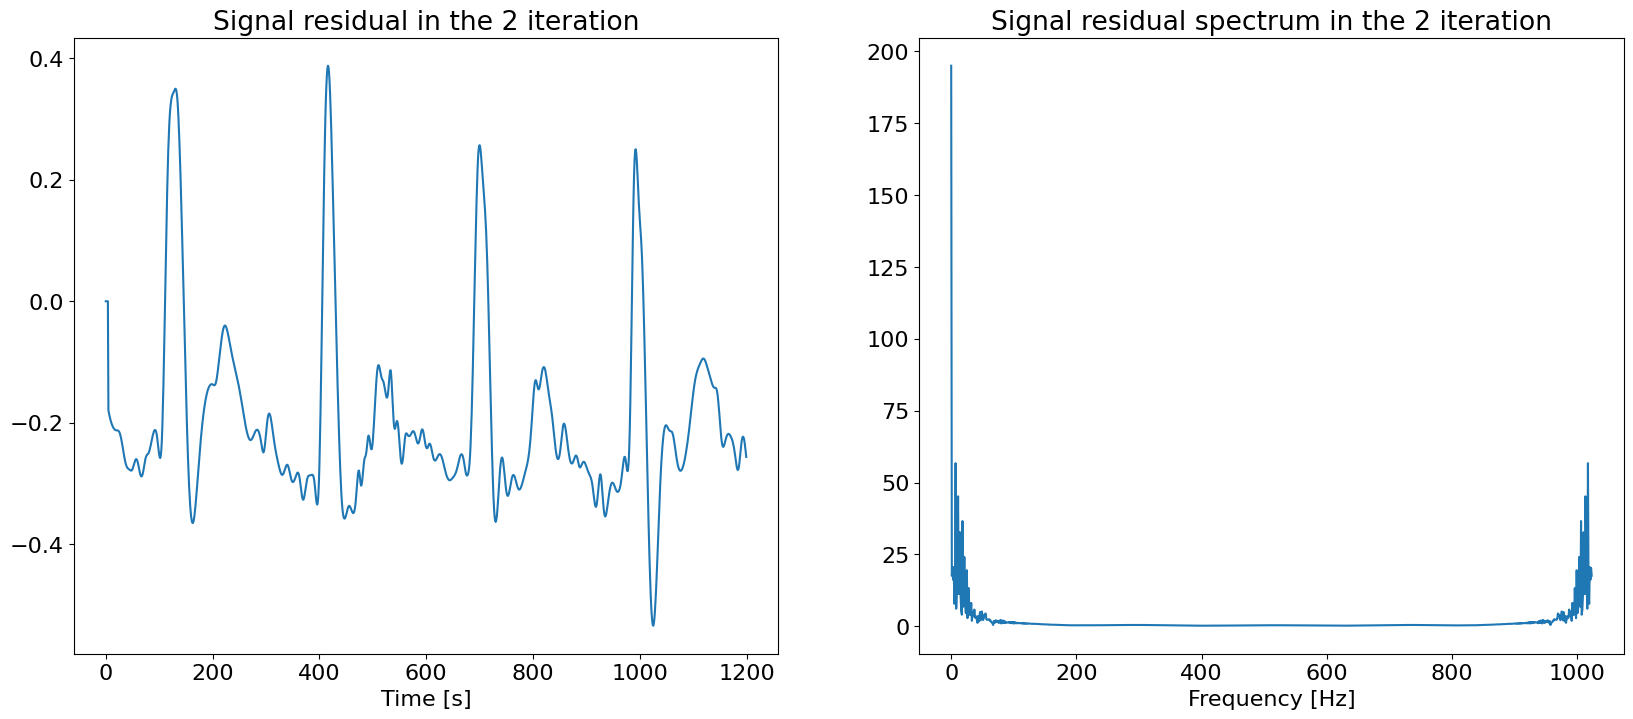

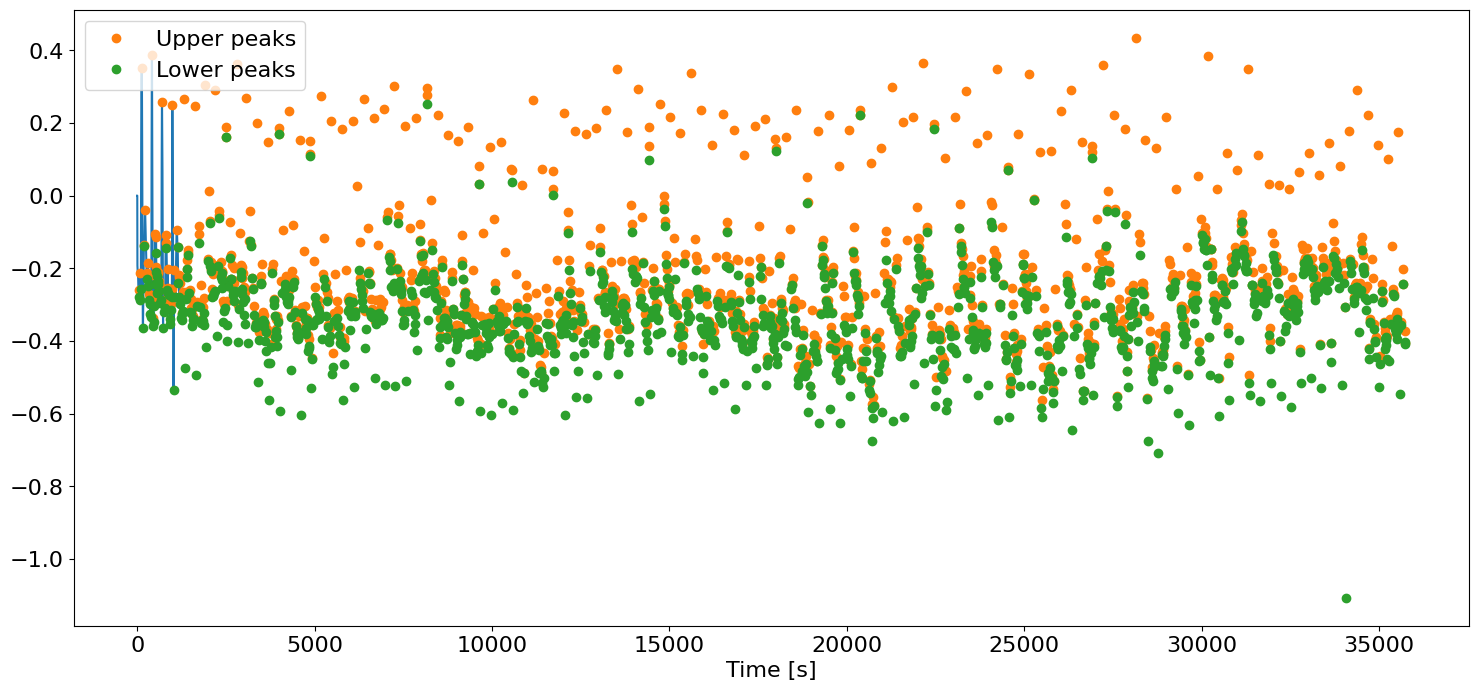

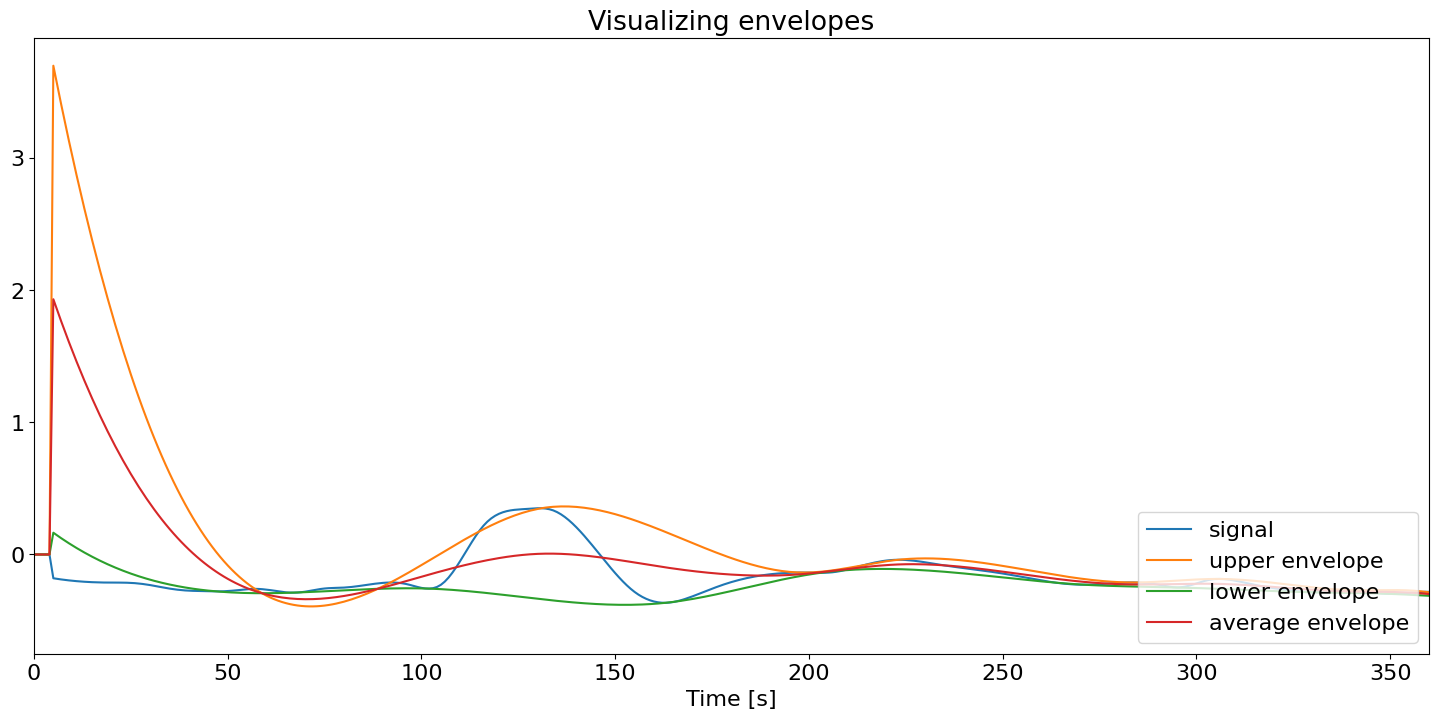

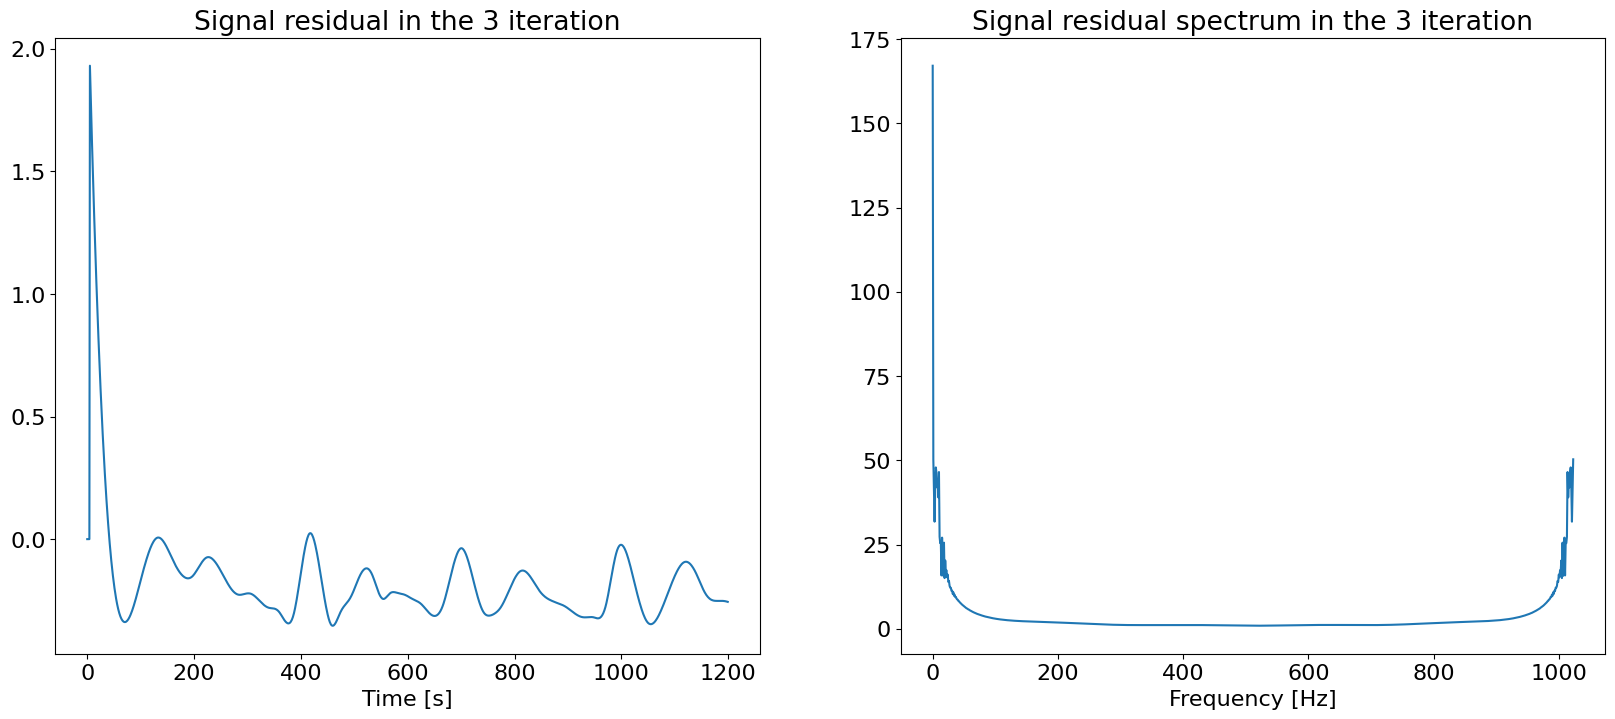

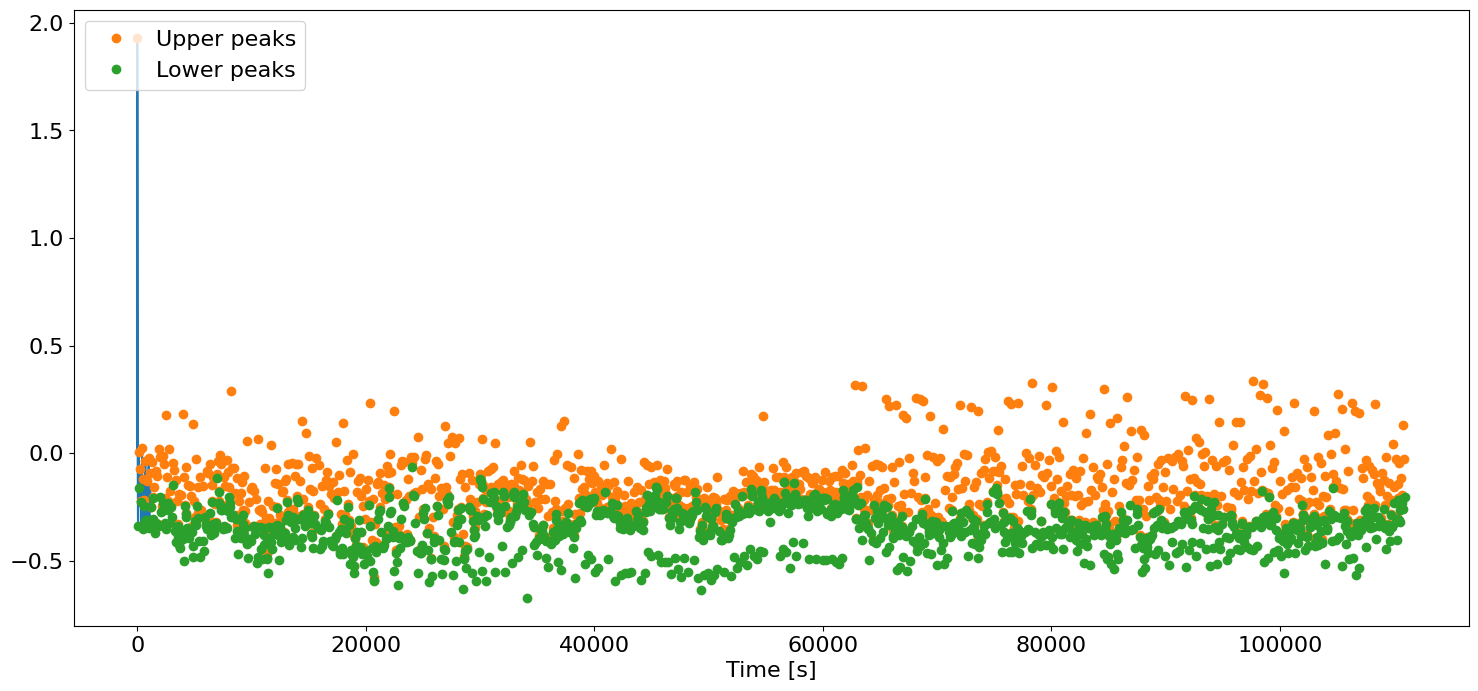

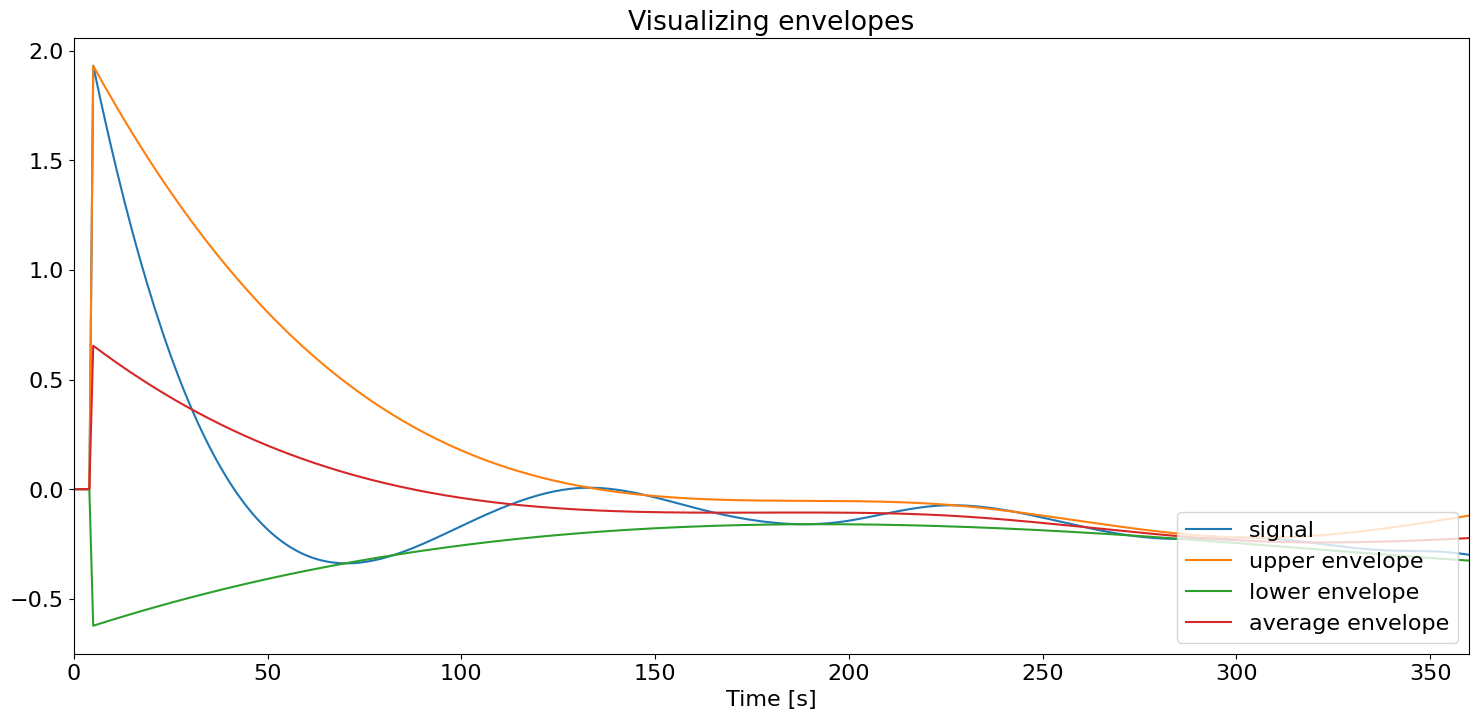

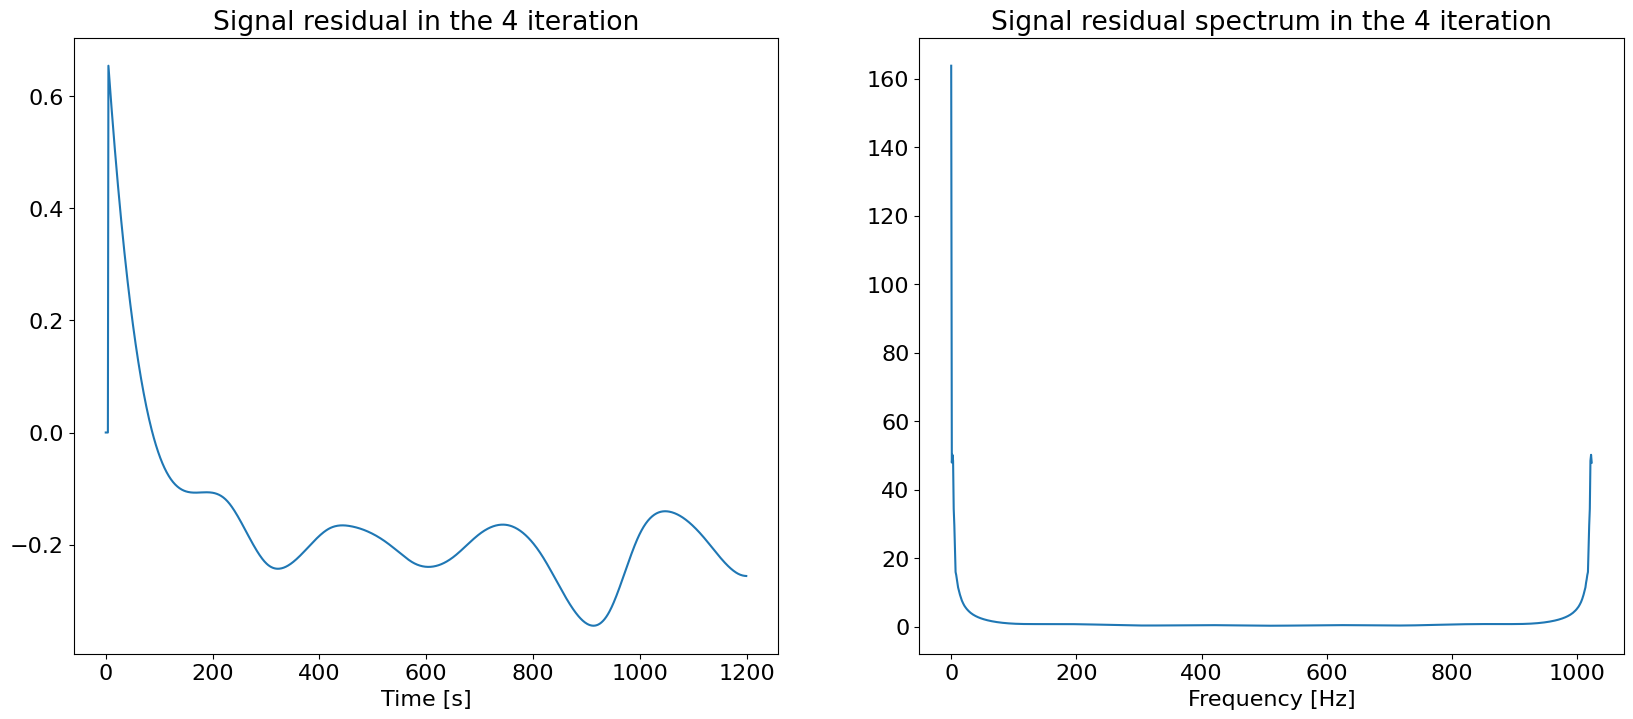

In [ ]:
# iteration 1
end_point=1200
res1 = emd_res(noisy_data[4],end_point,1)

# iteration 2
res2 = emd_res(res1,end_point,2)

# iteration 3
res3 = emd_res(res2,end_point,3)

# iteration 2
res4 = emd_res(res3,end_point,4)

Algorithm 2 - Autoregressive Model

In [ ]:
def auto_regressive_model(noisy_data,lag):
  filtered_data=[]
  for j in range(len(noisy_data)):
    model = AutoReg(noisy_data[j],lags=lag)
    result = model.fit()
    fitted_values = model.predict(result.params, start=0, end=len(noisy_data[j])-1)
    filtered_data.append(fitted_values)
  return filtered_data

<Figure size 640x480 with 0 Axes>

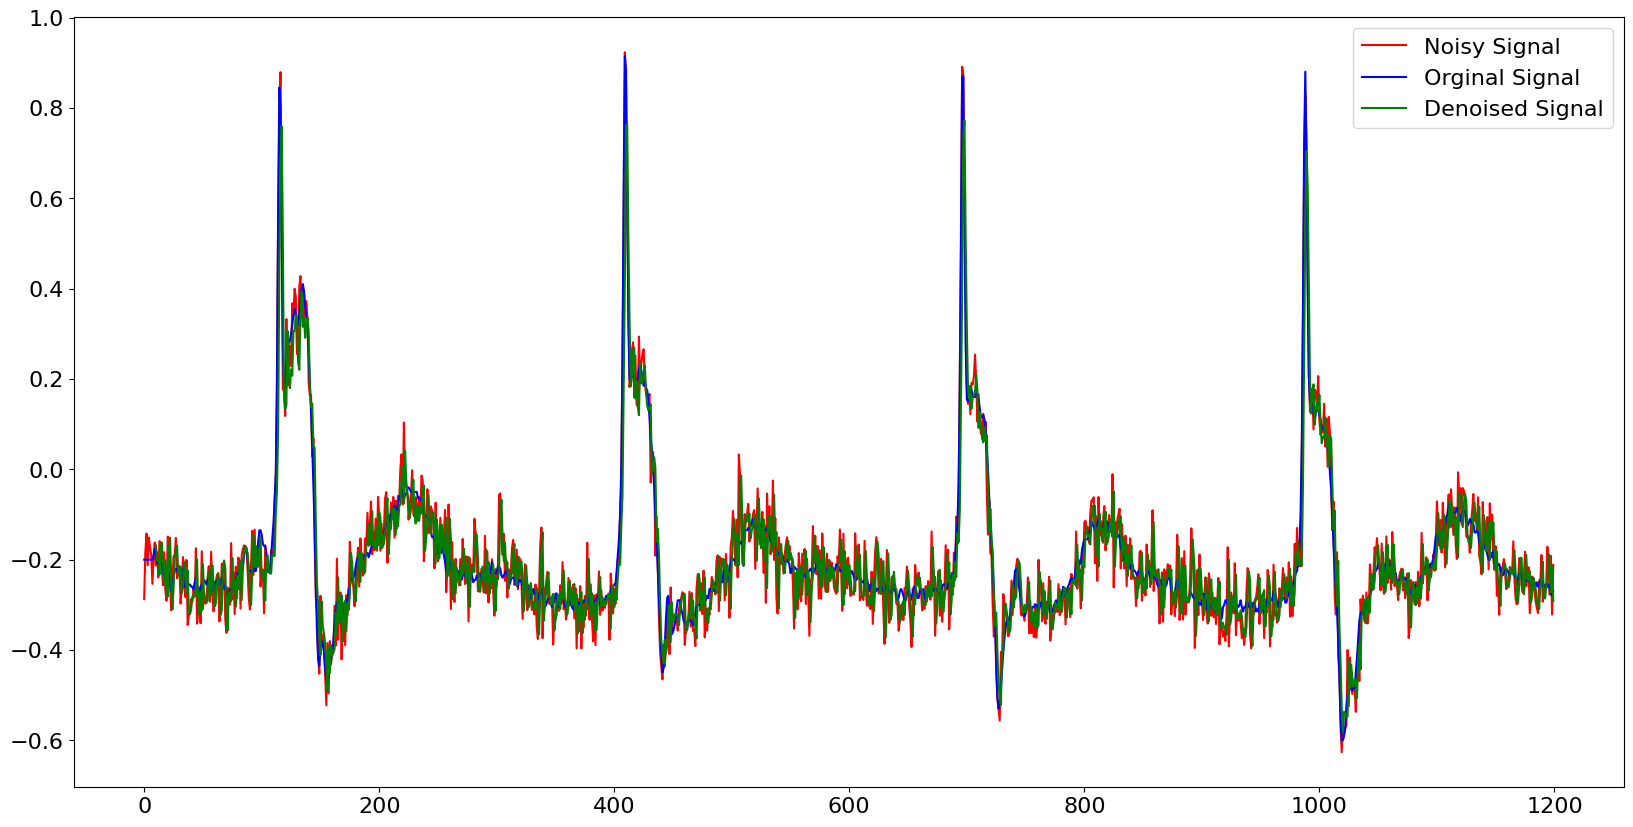

In [ ]:
filtered_data_ar=auto_regressive_model(noisy_data,10)
draw_noised_original_denoised_ecg_signal(noisy_data[4],data[4],filtered_data_ar[4])

<Figure size 640x480 with 0 Axes>

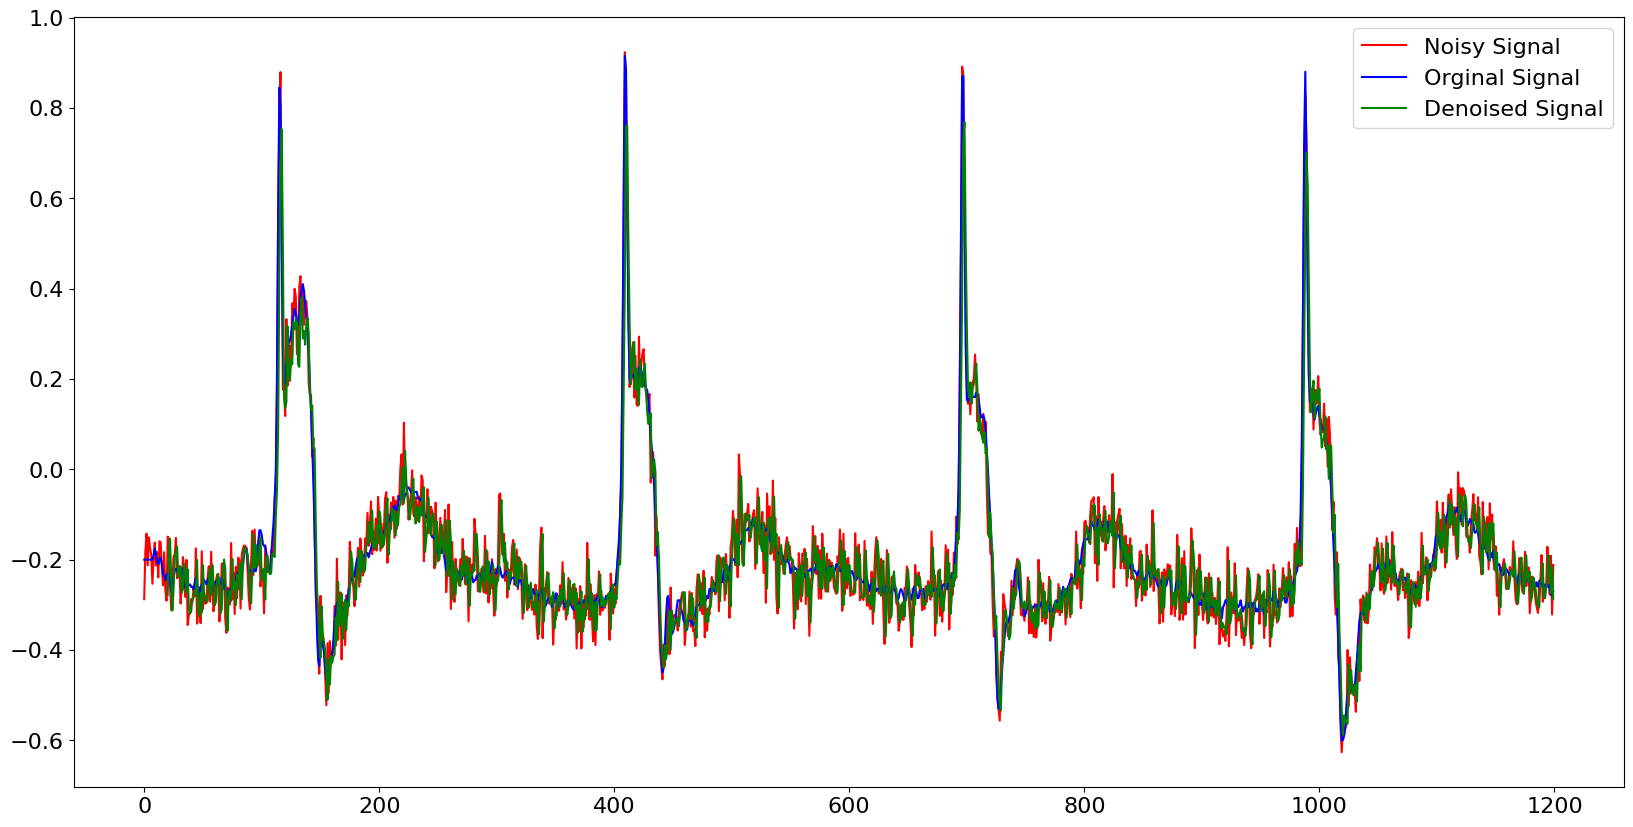

In [ ]:
filtered_data_ar2=auto_regressive_model(noisy_data,20)
draw_noised_original_denoised_ecg_signal(noisy_data[4],data[4],filtered_data_ar2[4])

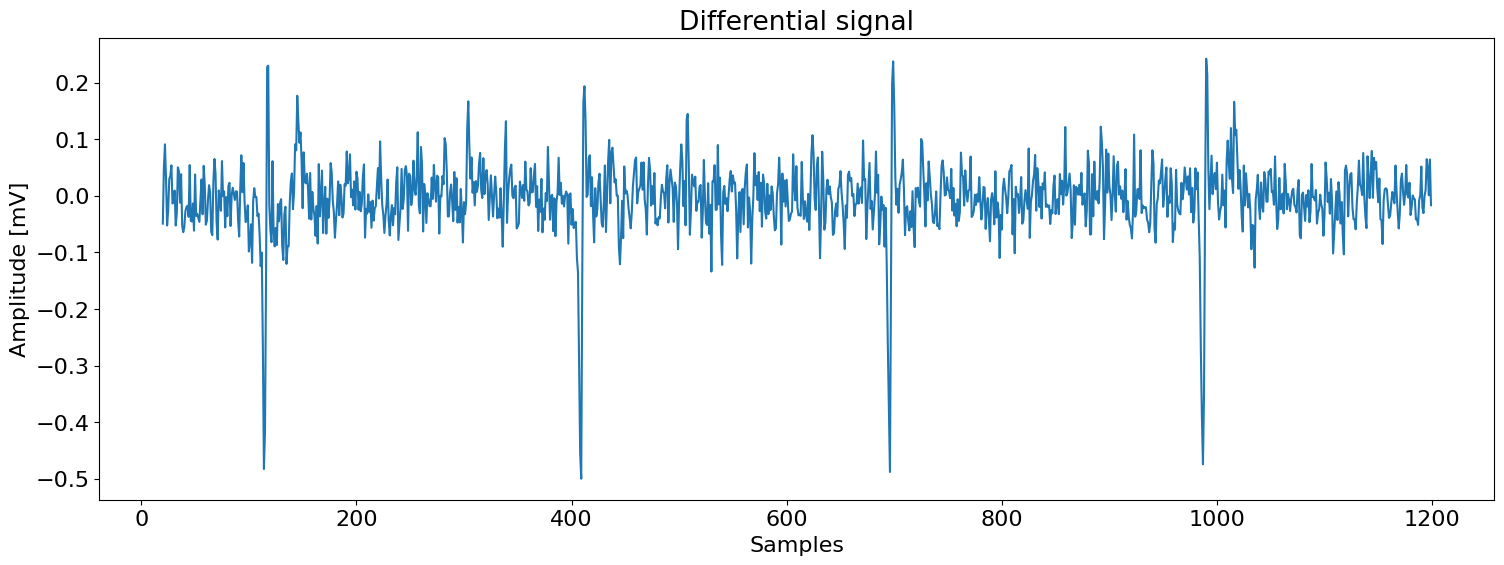

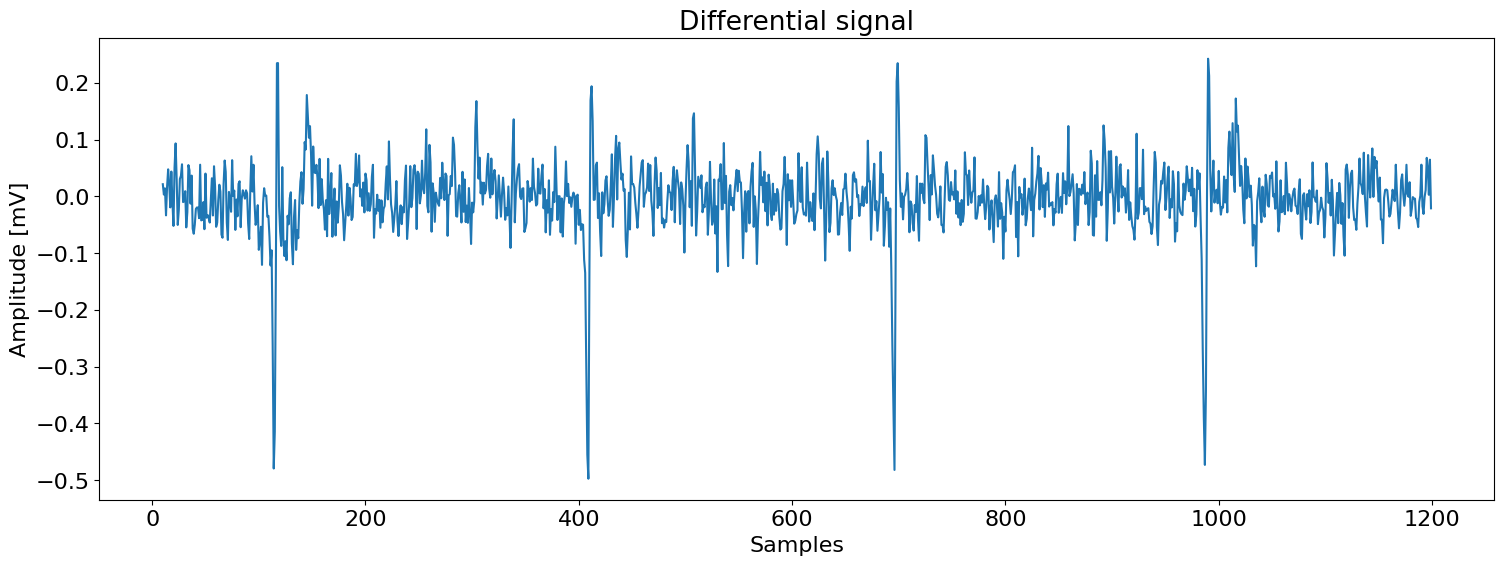

In [ ]:
draw_differential_signal(filtered_data_ar2[4],data[4])
draw_differential_signal(filtered_data_ar[4],data[4])

Algorithm 3 - Wavelet Transform

In [ ]:
def wavelet_denoising(noisy_data, wavelet, level=1):
  filtered_data=[]
  for j in range(len(data)):
    coeff = pywt.wavedec(noisy_data[j], wavelet, mode="per",level=level)
    var = statistics.variance(data[j]) # wariancja sygnalu
    uthresh = var * np.sqrt(2 * np.log(len(noisy_data[j]))) # ze wzoru - literatura
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    filtered_data.append(pywt.waverec(coeff, wavelet, mode='per'))
  return filtered_data

<Figure size 640x480 with 0 Axes>

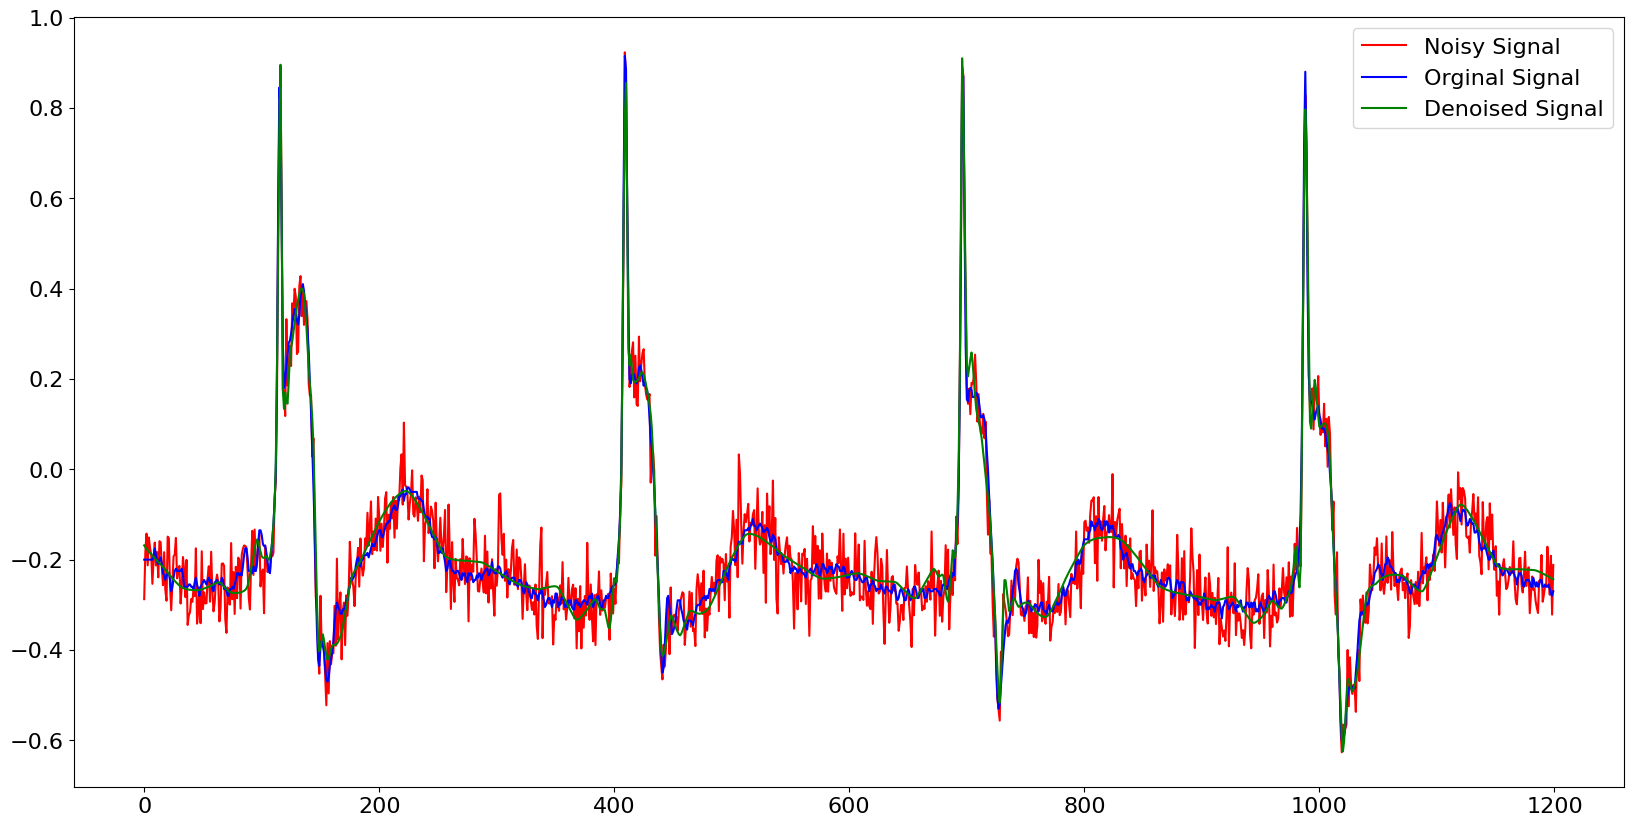

In [ ]:
wav='bior4.4'
w = pywt.Wavelet(wav)
maxlev = pywt.dwt_max_level(len(noisy_data[4]) + 1, w.dec_len)
filtered_data_bior4_4=wavelet_denoising(noisy_data, wavelet=wav, level=maxlev)
draw_noised_original_denoised_ecg_signal(noisy_data[4],data[4],filtered_data_bior4_4[4])

<Figure size 640x480 with 0 Axes>

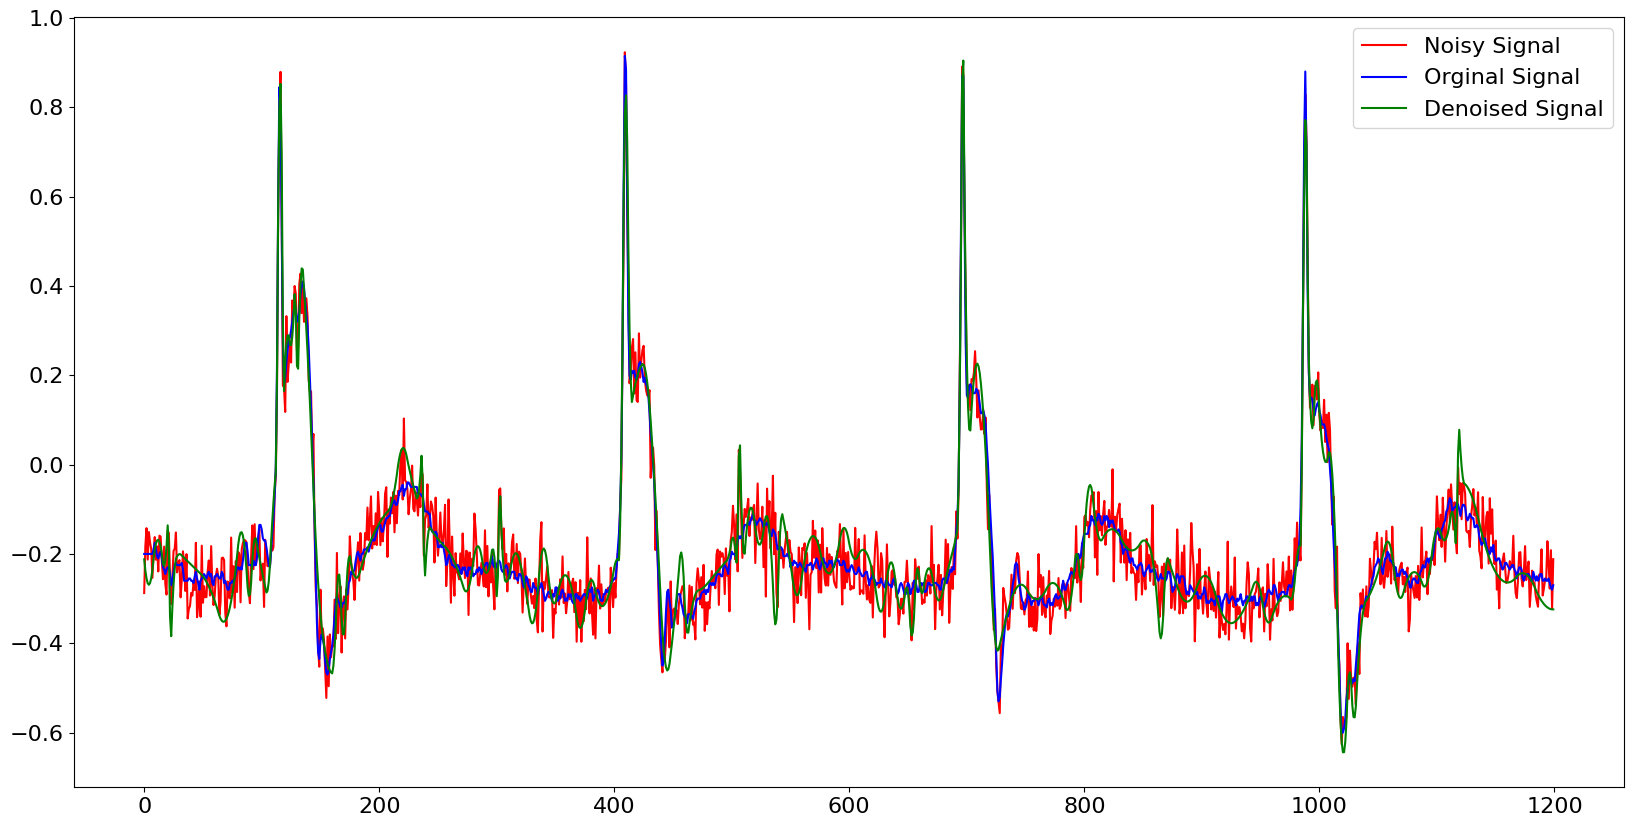

In [ ]:
wav='bior3.1'
w = pywt.Wavelet(wav)
maxlev = pywt.dwt_max_level(len(noisy_data[4]) + 1, w.dec_len)
filtered_data_bior3_1=wavelet_denoising(noisy_data, wavelet=wav, level=maxlev)
draw_noised_original_denoised_ecg_signal(noisy_data[4],data[4],filtered_data_bior3_1[4])

<Figure size 640x480 with 0 Axes>

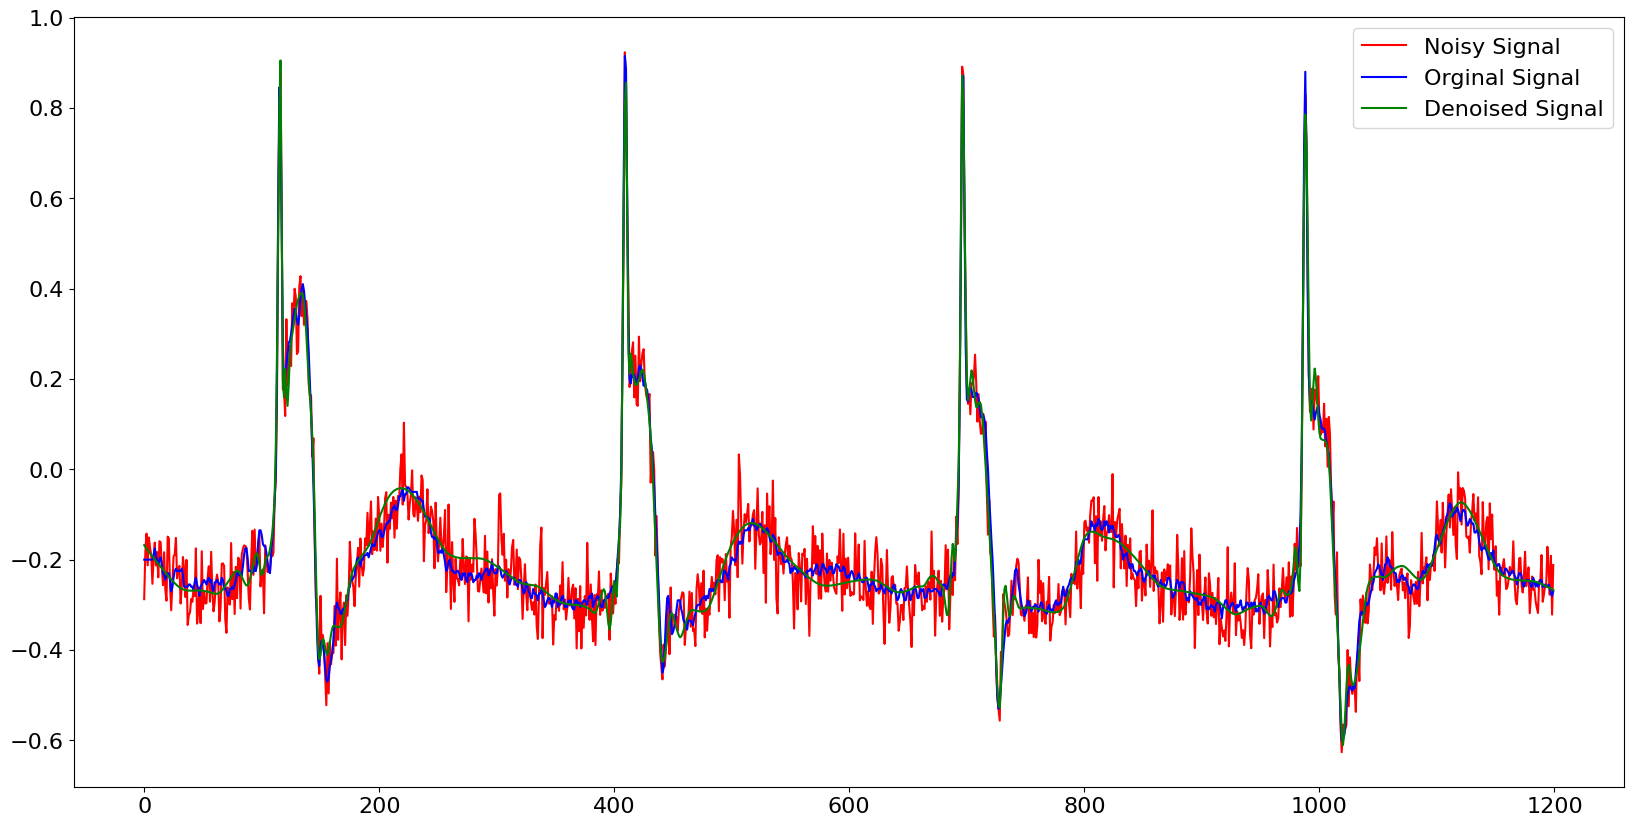

In [ ]:
wav='bior6.8'
w = pywt.Wavelet(wav)
maxlev = pywt.dwt_max_level(len(noisy_data[4]) + 1, w.dec_len)
filtered_data_bior6_8=wavelet_denoising(noisy_data, wavelet=wav, level=maxlev)
draw_noised_original_denoised_ecg_signal(noisy_data[4],data[4],filtered_data_bior6_8[4])

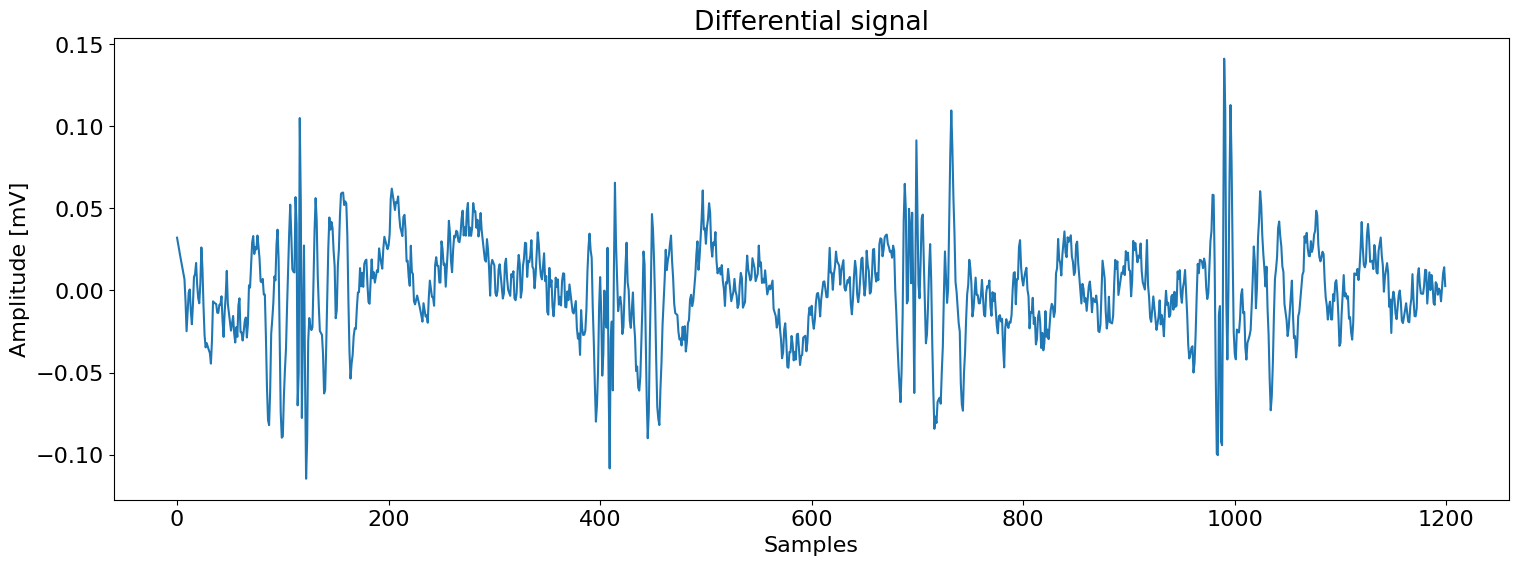

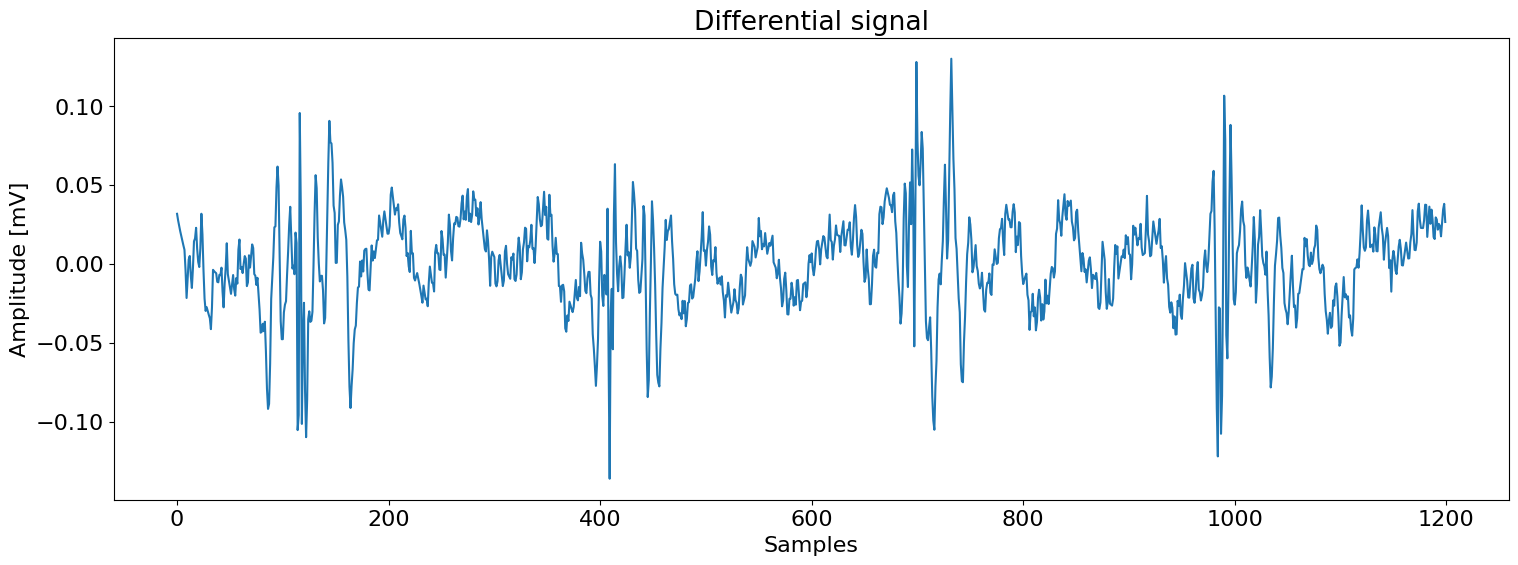

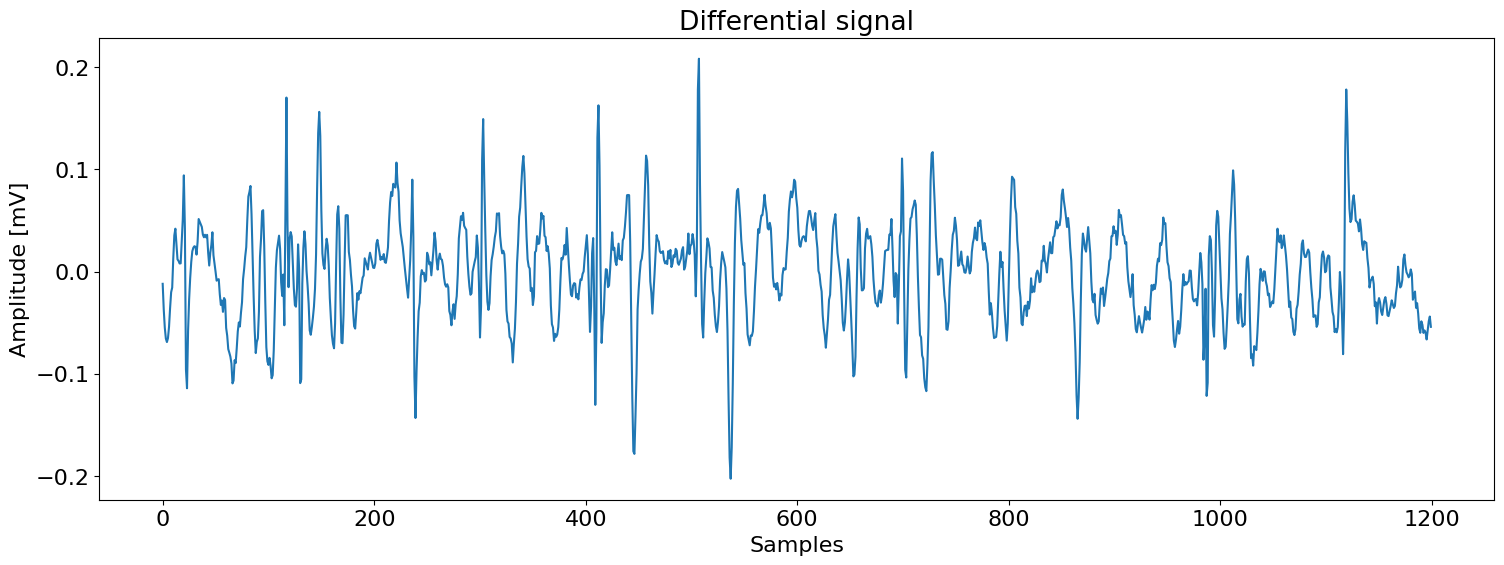

In [ ]:
draw_differential_signal(filtered_data_bior6_8[4],data[4])
draw_differential_signal(filtered_data_bior4_4[4],data[4])
draw_differential_signal(filtered_data_bior3_1[4],data[4])

Metrics

In [ ]:
def metrics_WT(filtered):
  waveletCorr=[]
  for i,j in zip(filtered, data):
    waveletCorr.append(crosscorr(i,j))
  return waveletCorr

In [ ]:
def ar_signal(signal,lag):
  denoised_signal_ar = []
  data_ar=[]
  for j in range(len(signal)):
    denoised_signal_ar.append(signal[j][lag:])
    data_ar.append(data[j][lag:])
  return denoised_signal_ar,data_ar

In [ ]:
def crosscorr(datax, datay):
    return pearsonr(datay,datax)

def MSE(filtered, signal):
    mse = mean_squared_error(filtered, signal)
    return mse

def MAE(filtered, signal):
    mae = mean_absolute_error(filtered, signal)
    return mae  

def SNR(filtered, noisy):
    filtered=np.array(filtered)
    noisy=np.array(noisy)
    VppFiltered = max(filtered) - min(filtered)
    VppNoisy = max(noisy) - min(noisy)
    snr = VppFiltered / VppNoisy
    snrDB = 20 * log10(snr)
    return snrDB

In [ ]:
def calculate_metrics(denoised,original):
  mse = []
  mae = []
  snr = []
  corr = []
  if denoised.ndim==1:
    print('f')
    snr=SNR(denoised,original)
    mse=MSE(denoised,original)
    mae=MAE(denoised,original)
    corr=crosscorr(denoised, original)[0]
  else:
      for i,j in zip(denoised, original):
          snr.append(SNR(i,j))
          mse.append(MSE(i,j[:i.shape[0]]))
          mae.append(MAE(i,j[:i.shape[0]]))
          corr.append(crosscorr(i, j[:i.shape[0]])[0])
      corr = sum(corr)/len(corr)
      snr = sum(snr)/len(snr)
      mse = sum(mse)/len(mse)
      mae = sum(mae)/len(mae)
  return corr,snr,mse,mae


def print_metrics(corr,snr,mse,mae,algorithm):
  print("Algorithm {} MSE = {} ".format(algorithm,mse))
  print("Algorithm {} MAE = {}".format(algorithm,mae))
  print("Algorithm {} SNR = {}".format(algorithm,snr))
  print("Algorithm {} CORR = {}".format(algorithm,corr))

In [ ]:
# EMD metrics
print(res1.ndim)

corr,snr,mse,mae=calculate_metrics(res1,data[4])
print_metrics(corr,snr,mse,mae,'EMD for res1')

corr,snr,mse,mae=calculate_metrics(res2,data[4])
print_metrics(corr,snr,mse,mae,'EMD for res2')

corr,snr,mse,mae=calculate_metrics(res3,data[4])
print_metrics(corr,snr,mse,mae,'EMD for res3')

1
f
Algorithm EMD for res1 MSE = 0.002841380561774288 
Algorithm EMD for res1 MAE = 0.030640331462526878
Algorithm EMD for res1 SNR = -1.503945165320897
Algorithm EMD for res1 CORR = 0.9600622679509911
f
Algorithm EMD for res2 MSE = 0.0059357166007770615 
Algorithm EMD for res2 MAE = 0.03623709787626459
Algorithm EMD for res2 SNR = -4.938882355387035
Algorithm EMD for res2 CORR = 0.9153756971610914
f
Algorithm EMD for res3 MSE = 0.01589521430254245 
Algorithm EMD for res3 MAE = 0.06336482568098448
Algorithm EMD for res3 SNR = -1.3345571082050953
Algorithm EMD for res3 CORR = 0.7596186778909655


In [ ]:
# AR model metrics
signal=filtered_data_ar
lag=10
denoised_signal_ar,data_ar=ar_signal(signal,lag)
corr,snr,mse,mae=calculate_metrics(denoised_signal_ar,data_ar)
print_metrics(corr,snr,mse,mae,'AR Model')

Algorithm AR Model MSE = 0.004273476027447919 
Algorithm AR Model MAE = 0.04772629291253321
Algorithm AR Model SNR = -0.10587541913888605
Algorithm AR Model CORR = 0.9778802975307578


In [ ]:
#WAVELET TRANSFORM
#SNR(filtered,signal)
wav1='bior3.1'
wav2='bior4.4'
wav3='bior6.8'

filtered_bior6_8=filtered_data_bior6_8
filtered_bior4_4=filtered_data_bior4_4
filtered_bior3_1=filtered_data_bior3_1

waveletCorr_bior3_1 = metrics_WT(filtered_bior3_1)
waveletCorr_bior4_4 = metrics_WT(filtered_bior4_4)
waveletCorr_bior6_8 = metrics_WT(filtered_bior6_8)

waveletCorr_bior3_1=np.array(waveletCorr_bior3_1)
waveletCorr_bior3_1=np.mean(waveletCorr_bior3_1[:,0])
print(f"Wartosc corr dla falki {wav1} wynosi {waveletCorr_bior3_1}  ")    

waveletCorr_bior4_4=np.array(waveletCorr_bior4_4)
waveletCorr_bior4_4=np.mean(waveletCorr_bior4_4[:,0])
print(f"Wartosc corr dla falki {wav2} wynosi {waveletCorr_bior4_4}  ")    

waveletCorr_bior6_8=np.array(waveletCorr_bior6_8)
waveletCorr_bior6_8=np.mean(waveletCorr_bior6_8[:,0])
print(f"Wartosc corr dla falki {wav3} wynosi {waveletCorr_bior6_8}  ")    

Wartosc corr dla falki bior3.1 wynosi 0.9639934251190457  
Wartosc corr dla falki bior4.4 wynosi 0.9702982875003476  
Wartosc corr dla falki bior6.8 wynosi 0.9733813652521808  
